# Test
### Fine-tuning and testing MAML on new data

In [1]:
import numpy as np
import cv2
import torch
from torch import nn
import os
from torchvision.datasets import ImageFolder
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import DataLoader
from model import MAMLClassifier

## Load Data

In [2]:
def load_images(path):
    '''Returns an array of images from a folder'''
    files = os.listdir(path)
    images = []
    
    for f in files:
        img_path = os.path.join(path, f)
        image = cv2.resize(cv2.imread(img_path), (28, 28)) / 255
        images.append(image)
        
    return torch.Tensor(images).float().permute(0, 3, 1, 2)

In [3]:
# Load Dataset and Create Dataloader
train_dataset = ImageFolder('digits/train/', transform=T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))

## Model

In [5]:
model = MAMLClassifier(n_way=5)

In [6]:
model.load_state_dict(torch.load('model_ckpt.pth')['weights'])

<All keys matched successfully>

## Single Step Fine-tuning

In [7]:
# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [9]:
def finetune(model, train_loader, criterion, optimizer, train_steps=1, device='cpu'):
    '''Fine-tune the meta trained model to a task specific dataset'''
    
    model.train()
    model.to(device)
    
    # Sample the train data
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        for step in range(train_steps):
            # Forward pass
            logits = model(X_train)
            # Loss
            loss = criterion(logits, y_train)
            # Backprop and Optimize
            loss.backward()
            optimizer.step()
        
        # Get Trained Loss and Accuracy
        logits = model(X_train)
        loss = criterion(logits, y_train)
        accuracy = torch.eq(logits.argmax(dim=-1), y_train).sum().item() / logits.shape[0]
        
        print(f'Loss {loss.item()} Accuracy {accuracy}')

In [10]:
finetune(model, train_loader, criterion, optimizer, train_steps=1)

Loss 0.051332343369722366 Accuracy 1.0


## Test

In [11]:
# Load test images
test_images = load_images('digits/test/')

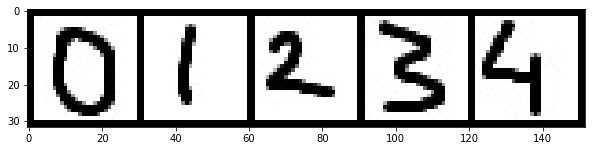

In [12]:
# Visualize Test Images
plot = torchvision.utils.make_grid(test_images, nrow=5)
plt.figure(figsize = (10,8))
plt.imshow(plot.permute(1, 2, 0))

In [13]:
# Make predictions
preds = model(test_images).argmax(dim=-1)
print('Predictions', preds.tolist())

Predictions [0, 1, 2, 3, 4]
